In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
    raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')


import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf



sys.path.append('../BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


# Matplotlib config
#============================
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"

def make_train_fig(figsize=(12,6),ncols=6, nrows=2,height_ratios= [1, 1],width_ratios= [16, 52,5,52,5,52]):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows, ncols, wspace=0,width_ratios=width_ratios,height_ratios=height_ratios)
    axes = gs.subplots(sharey=True)
    for ax in axes[:,1:].flatten():
        ax.yaxis.set_visible(False)
    return fig,axes

import matplotlib.transforms as mtransforms
def show_wire_on(df,**kwargs):
    wire_ROI = df['Wires'].dropna()
    plt.fill_between(wire_ROI.index, 0, 1, where= wire_ROI > 150,transform=mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes),**kwargs)

#============================       


def load_tracked(line_ID,folder = '../Sequential/Tracking/',sf=10):
    tracked = {}
    for label in ['ref','HO','LR','BBCW','OCTU']:
        tracked[label] = pd.read_pickle(f'{folder}/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'{folder}/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf

    _coord = tracked['coord']
    ctour_idx  = list(_coord[_coord['theta_sig'] == np.min(_coord['theta_sig'])].index)
    ctour_idx += list(_coord[_coord['r_sig'] == np.max(_coord['r_sig'])].index)[1:-1]
    ctour_idx += list(_coord[_coord['theta_sig'] == np.max(_coord['theta_sig'])].index)[::-1]
    ctour_idx += list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)[1:-1][::-1]
    tracked['ctour_idx'] = ctour_idx
    return tracked


def sum_footprints(_tracked,components,contour = False,at_intensity = None,at_current = None,at_mo_current = None):
    dQx,dQy = np.zeros(len(_tracked['coord'])),np.zeros(len(_tracked['coord']))

    rescale = {'HO':1,'LR':1,'BBCW':1,'OCTU':1}
    if at_intensity is not None:
        rescale['HO'] = at_intensity/1.4e11
        rescale['LR'] = at_intensity/1.4e11
    if at_current is not None:
        rescale['BBCW'] = at_current/350
    if at_mo_current is not None:
        rescale['OCTU'] = at_mo_current/430

    for i in components:
    #---------------
        _dQx = _tracked[i].tunes_n['Qx'] - _tracked['ref'].tunes_n['Qx']
        _dQy = _tracked[i].tunes_n['Qy'] - _tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*_tracked['sf']*rescale[i]
        dQy += _dQy*_tracked['sf']*rescale[i]
    #---------------


    if contour:

        dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    
    return dQx,dQy


# Extracting time info
B2_per_ID = pd.read_pickle('../Sequential/B2_per_ID.pkl')
macro = []
for idx in B2_per_ID.index:
    n = int(idx[2:4])
    if idx == 'ID10_t0':
        macro.append('ID05_t1')
        continue

    if idx == 'ID15_t0':
        macro.append('ID10_t1')
        continue

    if n < 5:
        macro.append('ID05_t0')
    elif 5<n<10:
        macro.append('ID05_t1')
    elif 10<n<15:
        macro.append('ID10_t1')
    elif n>15:
        macro.append('ID15_t1')
    else:
        macro.append(idx)
        
B2_per_ID.insert(0,'Macro ID',macro)
B2_per_ID.insert(0,'ID',B2_per_ID.index)
B2_per_ID.set_index('Timestamp',inplace=True)



In [13]:

# Loading all dataframes
tracked = {}
# for line_ID in ['ID05_t0','ID05_t0_test_emittance']:
for line_ID in ['ID05_t0','ID05_t1','ID10_t1','ID15_t1']:
    tracked[line_ID] = load_tracked(line_ID)

for line_ID in ['NEG']:
    tracked[line_ID] = load_tracked(line_ID,folder='../Octupoles_Guido/Tracking_FULL/')


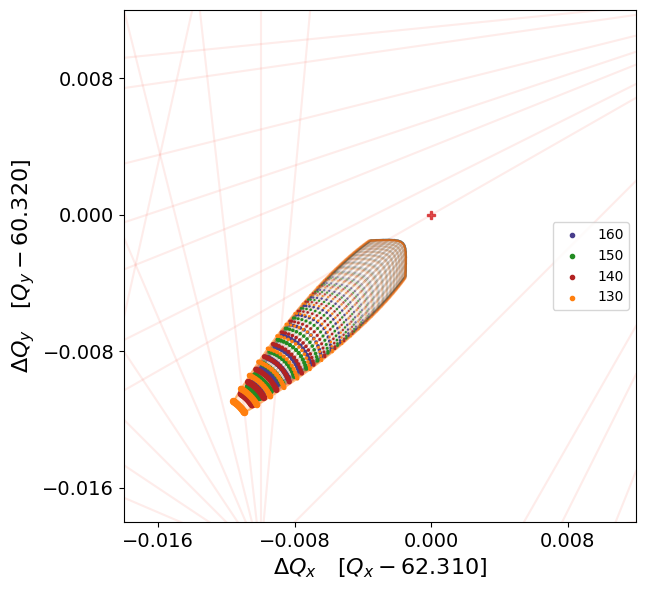

In [51]:
window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]



plt.figure(figsize=(8,6))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)

handles = [h1]
# for line_ID,color,label in zip( ['ID05_t0','NEG','ID05_t0_test_emittance'],['darkslateblue','forestgreen','firebrick'],['1.8','2.3','2.5']):
for line_ID,color,label in zip( ['ID05_t0','ID05_t1','ID10_t1','ID15_t1'],['darkslateblue','forestgreen','firebrick','C1'],['160','150','140','130']):


    _tracked = tracked[line_ID]
    dQx,dQy = sum_footprints(_tracked,components = ['HO'])

    # dQx = dQx*(float(label)/2.0)**(1/2)
    # dQy = dQy*(float(label)/2.0)**(1/2)

    bbplt.polarmesh(dQx,dQy,alpha=0.1,r=_tracked['coord']['r_sig'],theta=_tracked['coord']['theta_sig'],color=color)
    plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(_tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10,label=label)


    dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    start,stop = len(dQx)//4,len(dQx)//4+3

    plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
    # bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)

plt.legend()
plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)



plt.tight_layout()

# plt.savefig('./Checks/test_intensity_wire.png',dpi=300)

In [17]:

tracker = None
LINEFOLDER = '../Octupoles_Guido/Lines/'
line_ID = 'NEG'
for seq in ['lhcb4']:
    _beam = seq[-2:]
    # Importing Line
    line = xPlus.importLine(LINEFOLDER + f'line_{line_ID}_{seq}.json')

    tracker   = xt.Tracker(line=line)

Done loading line from dict.           
generating ./f6b854032a304d67bb17959c7b675fdd.c
the current directory is '/home/pbelanger/ABPlocal/FPCatalogue'
running build_ext
building 'f6b854032a304d67bb17959c7b675fdd' extension
gcc -pthread -B /home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/include -I/home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/include -fPIC -I/home/pbelanger/ABPlocal/BBStudies/Executables/py_BB/include -I/home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/include/python3.9 -c f6b854032a304d67bb17959c7b675fdd.c -o ./f6b854032a304d67bb17959c7b675fdd.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/pbelanger/ABPlocal/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/pbelanger/ABPlocal/BBStudie

In [47]:


def gen_coord(emittx_n,emitty_n):
    contour = False
    coordinates = phys.polar_grid(  r_sig     = np.array([1e-6] + list(np.linspace(1,6.5,23))),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                    emitt     = [emittx_n/tracker.line.particle_ref.gamma0,emitty_n/tracker.line.particle_ref.gamma0])
    coordinates.insert(0,'delta',0)


    if contour:
        ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.max(coordinates['r_sig'])].index)[1:-1]
        ctour_idx += list(coordinates[coordinates['theta_sig'] == np.max(coordinates['theta_sig'])].index)[::-1]
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.min(coordinates['r_sig'])].index)[1:-1][::-1]

        coordinates = coordinates.loc[ctour_idx]

    group_length = len(coordinates)

    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( method       = '4d',
                                    particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [emittx_n,emitty_n])
    return coordinates,particles




In [41]:
np.concatenate([[0.1],np.linspace(1,6.5,23)])

array([0.1 , 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25,
       3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  ,
       6.25, 6.5 ])

In [42]:
np.array([0.1] + list(np.linspace(1,6.5,23)))

array([0.1 , 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25,
       3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  ,
       6.25, 6.5 ])

(-1e-06, 1e-06)

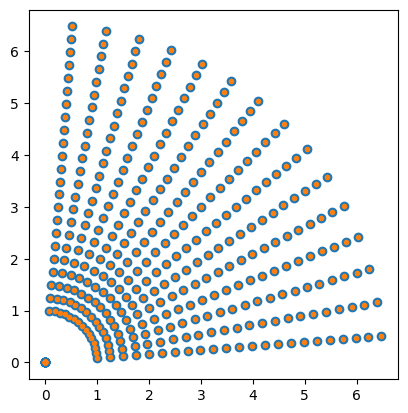

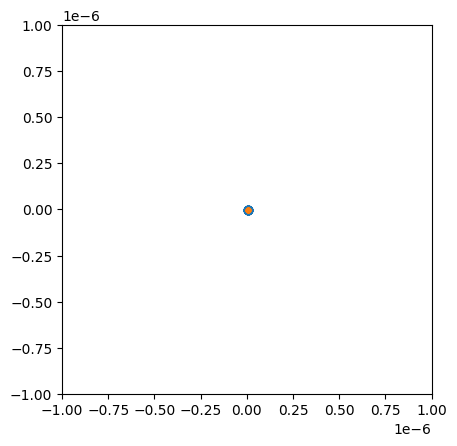

In [50]:

coordinates,particles = gen_coord(2.5e-6,2.5e-6)


plt.figure()
coordinates,particles = gen_coord(2.0e-6,2.0e-6)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o')
coordinates,particles = gen_coord(1.0e-6,1.0e-6)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.')
plt.axis('square');


plt.figure()
coordinates,particles = gen_coord(2.0e-6,2.0e-6)
plt.plot(particles.x,particles.y,'o')
coordinates,particles = gen_coord(1.0e-6,1.0e-6)
plt.plot(particles.x,particles.y,'.')
plt.axis('square');

plt.xlim([-0.000001,0.000001])
plt.ylim([-0.000001,0.000001])



array([2.10966857e-04, 2.63707138e-04, 3.16447419e-04, 3.69187700e-04,
       4.21927981e-04, 4.74668262e-04, 5.27408543e-04, 5.80148824e-04,
       6.32889105e-04, 6.85629386e-04, 7.38369667e-04, 7.91109948e-04,
       8.43850229e-04, 8.96590510e-04, 9.49330791e-04, 1.00207107e-03,
       1.05481135e-03, 1.10755163e-03, 1.16029192e-03, 1.21303220e-03,
       1.26577248e-03, 1.31851276e-03, 1.37125304e-03, 2.09345864e-04,
       2.61680897e-04, 3.14015929e-04, 3.66350962e-04, 4.18685995e-04,
       4.71021028e-04, 5.23356060e-04, 5.75691093e-04, 6.28026126e-04,
       6.80361159e-04, 7.32696192e-04, 7.85031224e-04, 8.37366257e-04,
       8.89701290e-04, 9.42036323e-04, 9.94371355e-04, 1.04670639e-03,
       1.09904142e-03, 1.15137645e-03, 1.20371149e-03, 1.25604652e-03,
       1.30838155e-03, 1.36071658e-03, 2.05592061e-04, 2.56988643e-04,
       3.08385225e-04, 3.59781807e-04, 4.11178389e-04, 4.62574971e-04,
       5.13971553e-04, 5.65368136e-04, 6.16764718e-04, 6.68161300e-04,
      